In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from hyperopt import fmin,STATUS_OK,Trials,hp,tpe
import mlflow
from mlflow.models import infer_signature

2025-10-17 21:07:31.136844: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


importacion de los datasets cifar10 de tensorflow

(50000, 32, 32, 3)
(50000, 1)


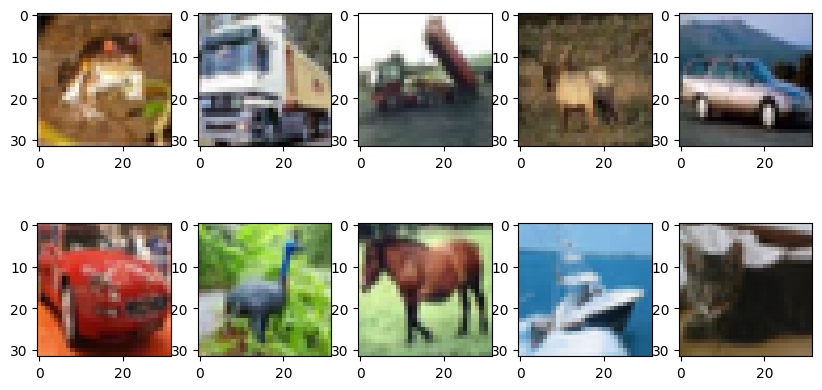

In [2]:
dataset = keras.datasets.cifar10
(train_images, train_labels), (test_images,test_labels) = dataset.load_data()

#vemos las dimensiones con las que nos llegan el dataset
#para este caso es de 50.000 elementos con 32px x 32px, en 3 dimensiones
print(train_images.shape)

# mask = train_labels
# train_images, train_labels = train_images[train_labels.flatten()], train_labels[train_labels.flatten()]
# test_images, test_labels = test_images[test_labels.flatten()],test_labels[test_labels.flatten()]

train_images, test_images = train_images / 255.0, test_images / 255.0

#tiene 50k elementos en los cuales van desde 0 a 10 para identificar las categorias
print(train_labels.shape)

#generamos un subplot para organizar como se muestran las imagenes
fig,axes = plt.subplots(2,5,figsize=(10,5))

#iteramos las imagenes colocandolas en subplots
i=0
for ax in axes.flat:
    ax.imshow(train_images[i])
    i += 1
#mostramos las imagenes
plt.show()


A partir de las imagenes determinamos las categorias que hay en el dataset

In [3]:
class_names = ['avion','auto','pajaro', 'gato','ciervo','perro','sapo','caballo','barco','camion']

print(train_images.shape)

(50000, 32, 32, 3)


creamos las tuplas de matrices NumPy,
como las imagenes ya se encuentran en el formato solicitado
no es necesario realizar un reshape

In [4]:
# x_train = train_images
# y_train = train_labels.flatten()
# x_test = test_images[:5000]
# y_test = test_labels[:5000].flatten()
# x_val = test_images[5000:]
# y_val = test_labels[5000:].flatten()
x_train, x_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=42
)
x_test = test_images
y_test = test_labels

signature = infer_signature(x_train,y_train)

In [5]:
def train_model(params,epochs,x_train,y_train,x_test,y_test,x_val,y_val):
    print(params)
    #para el data augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.08,
        height_shift_range=0.08,
        horizontal_flip=True, 
        zoom_range=0.08,
        fill_mode='nearest'
    )
    model1 = keras.Sequential([
        #primera capa convolucional seguido de un maxpooling y dropout
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.2),
        #segunda capa
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        #tercera capa
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        #flatten
        #layers.Flatten(input_shape=(32,32,3)),
        #capa densa completamente conectada
        # layers.Dense(128,activation='relu'),
        # layers.Dropout(0.5),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256,activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10,activation='softmax')
    ])
    model1.summary()
    model1.compile(optimizer = keras.optimizers.AdamW(learning_rate=params['learning_rate'],beta_1=params['beta_1'],beta_2=params['beta_2'],clipnorm=1.0),
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy']
    )

    early_stop = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True,min_delta=0.001,verbose=1)
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-5,
        verbose=1
    )

    
    #train model with diferents params with mlfl ow tracking
    with mlflow.start_run(nested=True):
        history = model1.fit(datagen.flow(x_train,y_train,batch_size=64),epochs=epochs,validation_data=(x_val,y_val),callbacks=[early_stop,reduce_lr])
        test_loss, test_accuracy = model1.evaluate(x_test,y_test)

        mlflow.log_params(params)
        mlflow.log_metrics({
            "test_loss": test_loss,
            "test_accuracy": test_accuracy
        },step=epochs)
        
        for epoch in range(len(history.history['loss'])):
            mlflow.log_metric("train_loss", history.history['loss'][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
            mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], step=epoch)
            mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)

        mlflow.keras.log_model(model1,"modelo_cnn",signature=signature)
        model1.save("best_model.keras")
        return {
            "loss": test_loss,
            "status": STATUS_OK,
            "model": model1,
        }



In [ ]:
def objective(params):
    #para que mlflow pueda registrar los parametros y resultados en cada iteracion
    result = train_model(
        params=params,
        epochs=35,
        x_train=x_train,
        y_train=y_train,
        x_test=x_test,
        y_test=y_test,
        x_val=x_val,
        y_val=y_val)
    return result

In [7]:
space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(1e-5), np.log(1e-3)),
    "beta_1": hp.uniform("beta_1", 0.85, 0.95),
    "beta_2": hp.quniform("beta_2", 0.99, 0.9999, 0.0001),
    # "batch_size": hp.choice("batch_size", [16, 32, 64, 128]),
    # "weight_decay": hp.loguniform("weight_decay", np.log(1e-6), np.log(1e-3)),
}


In [ ]:
mlflow.set_experiment("/cnn_clasification")
with mlflow.start_run():
    trials = Trials()
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=10,
        trials=trials
    )
    best_run = sorted(trials.results,key=lambda x: x["loss"])[0]
    mlflow.log_params(best)
    mlflow.log_metric("Loss",best_run["loss"])
    mlflow.tensorflow.log_model(best_run["model"],"model",signature=signature)

    #mostrar mejores parametros
    print(f"Los mejores parametros son: {best}")
    print(f"El loss mas bajo conseguido es: {best_run['loss']}")

{'beta_1': 0.949360768082994, 'beta_2': 0.995, 'learning_rate': 0.00019588170263476574}
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

/home/ubuntu/cnnmodelofabri/myvenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

I0000 00:00:1760746083.937484     933 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,722 (1.75 MB)

 Trainable params: 458,250 (1.75 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/30                                           

  0%|          | 0/5 [00:06<?, ?trial/s, best loss=?]

/home/ubuntu/cnnmodelofabri/myvenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()

2025-10-17 21:08:09.684925: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f54b8009880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-17 21:08:09.684957: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-10-17 21:08:09.833552: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-17 21:08:10.855237: I external/local_xla/xla/stre

  1/704 ━━━━━━━━━━━━━━━━━━━━ 2:32:55 13s/step - accuracy: 0.0938 - loss: 3.4415
  3/704 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.0755 - loss: 3.4999   
                                                     

I0000 00:00:1760746099.630824    1235 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  5/704 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.0827 - loss: 3.4652
  7/704 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.0934 - loss: 3.3938
  9/704 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.1001 - loss: 3.3493
 11/704 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.1073 - loss: 3.3100
 14/704 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.1152 - loss: 3.2671
 17/704 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.1222 - loss: 3.2299
 20/704 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.1285 - loss: 3.1958
 23/704 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.1343 - loss: 3.1663
 26/704 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.1393 - loss: 3.1417
 29/704 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.1439 - loss: 3.1185
 32/704 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.1482 - loss: 3.0968
 35/704 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.1522 - loss: 3.0770
 37/704 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.1547 - loss: 3.0643

2025-10-17 21:08:22.842266: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3415', 8 bytes spill stores, 8 bytes spill loads



 76/704 ━━━━━━━━━━━━━━━━━━━━ 1:13 116ms/step - accuracy: 0.1858 - loss: 2.8949
 77/704 ━━━━━━━━━━━━━━━━━━━━ 1:12 116ms/step - accuracy: 0.1863 - loss: 2.8920
 78/704 ━━━━━━━━━━━━━━━━━━━━ 1:12 115ms/step - accuracy: 0.1868 - loss: 2.8891
 79/704 ━━━━━━━━━━━━━━━━━━━━ 1:11 115ms/step - accuracy: 0.1872 - loss: 2.8862
 81/704 ━━━━━━━━━━━━━━━━━━━━ 1:10 113ms/step - accuracy: 0.1882 - loss: 2.8806
 86/704 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - accuracy: 0.1904 - loss: 2.8671
 89/704 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - accuracy: 0.1917 - loss: 2.8594
 92/704 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - accuracy: 0.1928 - loss: 2.8520
 95/704 ━━━━━━━━━━━━━━━━━━━━ 59s 98ms/step - accuracy: 0.1940 - loss: 2.8449  
 98/704 ━━━━━━━━━━━━━━━━━━━━ 58s 96ms/step - accuracy: 0.1951 - loss: 2.8380
101/704 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - accuracy: 0.1962 - loss: 2.8313
104/704 ━━━━━━━━━━━━━━━━━━━━ 54s 92ms/step - accuracy: 0.1972 - loss: 2.8247
107/704 ━━━━━━━━━━━━━━━━━━━━ 53s 90ms/step - accuracy: 0.1

2025-10-17 21:08:42.761435: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 61440000 exceeds 10% of free system memory.
2025-10-17 21:08:42.906314: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 61440000 exceeds 10% of free system memory.


704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.3268 - loss: 2.1104 - val_accuracy: 0.3364 - val_loss: 2.5089 - learning_rate: 1.9588e-04

Epoch 2/30                                           

  1/704 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.4844 - loss: 1.9706
  3/704 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.4557 - loss: 1.9278
  4/704 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.4463 - loss: 1.9159
  6/704 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.4309 - loss: 1.9068
  8/704 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.4186 - loss: 1.9200
 10/704 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.4092 - loss: 1.9317
 12/704 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.4039 - loss: 1.9317
 14/704 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.4009 - loss: 1.9264
 16/704 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.3990 - loss: 1.9200
 17/704 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.3986 - loss: 1.9169
 18/704 ━━━━━━━━━━━━━━━━━━━

2025-10-17 21:15:04.916130: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 122880000 exceeds 10% of free system memory.
2025-10-17 21:15:05.221033: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 122880000 exceeds 10% of free system memory.


 11/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7183 - loss: 0.8766
 15/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7110 - loss: 0.8937
 20/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7076 - loss: 0.8977
 26/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7044 - loss: 0.8990
 33/313 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7020 - loss: 0.9031
 39/313 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7020 - loss: 0.9013
 46/313 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7022 - loss: 0.8978
 53/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7021 - loss: 0.8964 
 59/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7025 - loss: 0.8954
 67/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7023 - loss: 0.8960
 74/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7015 - loss: 0.8981
 81/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7005 - loss: 0.9009
 88/313 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6992 - loss: 0.9043
 95/313 ━━━━━━━━━

2025/10/17 21:15:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



{'beta_1': 0.8641034119095342, 'beta_2': 0.9937, 'learning_rate': 0.0005793436807019373}
 20%|██        | 1/5 [07:20<29:20, 440.03s/trial, best loss: 0.9287312626838684]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,722 (1.75 MB)

 Trainable params: 458,250 (1.75 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/30                                                                      

  1/704 ━━━━━━━━━━━━━━━━━━━━ 1:29:27 8s/step - accuracy: 0.0625 - loss: 3.7535
  2/704 ━━━━━━━━━━━━━━━━━━━━ 1:48 155ms/step - accuracy: 0.0898 - loss: 3.5848
  3/704 ━━━━━━━━━━━━━━━━━━━━ 1:22 118ms/step - accuracy: 0.0964 - loss: 3.5039
  6/704 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.1150 - loss: 3.3570  
  9/704 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.1287 - loss: 3.2881
 12/704 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.1376 - loss: 3.2291
 15/704 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.1423 - loss: 3.1900
 18/704 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.1466 - loss: 3.1609
 21/704 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.1512 - loss: 3.1323
 23/704 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.1539 - loss: 3.1171
 26/704 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.1582 - loss: 3.0947
 28/704 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.1612 -

2025-10-17 21:15:50.091623: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 61440000 exceeds 10% of free system memory.


704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.3734 - loss: 1.8862 - val_accuracy: 0.3990 - val_loss: 2.4046 - learning_rate: 5.7934e-04

Epoch 2/30                                                                      

  1/704 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.5156 - loss: 1.4372
  3/704 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.5130 - loss: 1.3718
  5/704 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.5205 - loss: 1.3515
  7/704 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5154 - loss: 1.3753
  9/704 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5082 - loss: 1.3998
 11/704 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5022 - loss: 1.4246
 13/704 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.4998 - loss: 1.4387
 15/704 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.4990 - loss: 1.4453
 17/704 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.4985 - loss: 1.4486
 20/704 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.4994 - loss: 1.4481


2025/10/17 21:22:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



{'beta_1': 0.9003505342335376, 'beta_2': 0.9947, 'learning_rate': 0.00027002305490365236}
 40%|████      | 2/5 [14:09<21:06, 422.14s/trial, best loss: 0.5863434076309204]

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,722 (1.75 MB)

 Trainable params: 458,250 (1.75 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/30                                                                      

  1/704 ━━━━━━━━━━━━━━━━━━━━ 1:08:27 6s/step - accuracy: 0.1406 - loss: 3.3835
  2/704 ━━━━━━━━━━━━━━━━━━━━ 53s 76ms/step - accuracy: 0.1562 - loss: 3.3181  
  5/704 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.1701 - loss: 3.2006
  8/704 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.1750 - loss: 3.1442
 11/704 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.1738 - loss: 3.1221
 14/704 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.1723 - loss: 3.1090
 16/704 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.1719 - loss: 3.1008
 19/704 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.1728 - loss: 3.0828
 22/704 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.1732 - loss: 3.0665
 25/704 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.1747 - loss: 3.0486
 28/704 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.1765 - loss: 3.0297
 31/704 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.1780 - los

2025/10/17 21:27:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



{'beta_1': 0.8552829439838745, 'beta_2': 0.9987, 'learning_rate': 0.00027260924211726557}
 60%|██████    | 3/5 [19:57<12:56, 388.05s/trial, best loss: 0.5863434076309204]

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,722 (1.75 MB)

 Trainable params: 458,250 (1.75 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/30                                                                      

  1/704 ━━━━━━━━━━━━━━━━━━━━ 1:23:48 7s/step - accuracy: 0.1406 - loss: 3.1637
  2/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.1250 - loss: 3.2370  
  5/704 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.1294 - loss: 3.2059
  8/704 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.1400 - loss: 3.1625
 11/704 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.1465 - loss: 3.1224
 14/704 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.1509 - loss: 3.0897
 17/704 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.1554 - loss: 3.0656
 20/704 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.1590 - loss: 3.0396
 23/704 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.1618 - loss: 3.0168
 26/704 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.1641 - loss: 2.9972
 29/704 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.1663 - loss: 2.9795
 32/704 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.1684 - los

2025/10/17 21:34:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



{'beta_1': 0.8947657295743163, 'beta_2': 0.9981000000000001, 'learning_rate': 2.5010849304908624e-05}
 80%|████████  | 4/5 [26:21<06:26, 386.49s/trial, best loss: 0.5863434076309204]

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,722 (1.75 MB)

 Trainable params: 458,250 (1.75 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/30                                                                      

  1/704 ━━━━━━━━━━━━━━━━━━━━ 1:25:11 7s/step - accuracy: 0.1250 - loss: 3.3647
  2/704 ━━━━━━━━━━━━━━━━━━━━ 1:42 147ms/step - accuracy: 0.1133 - loss: 3.4668
  4/704 ━━━━━━━━━━━━━━━━━━━━ 48s 69ms/step - accuracy: 0.1035 - loss: 3.5763  
  6/704 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - accuracy: 0.1026 - loss: 3.5995
  8/704 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.1037 - loss: 3.5970
 11/704 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.1051 - loss: 3.5862
 14/704 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.1055 - loss: 3.5778
 17/704 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.1048 - loss: 3.5708
 19/704 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.1045 - loss: 3.5653
 22/704 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.1044 - loss: 3.5540
 25/704 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.1053 - loss: 3.5370
 28/704 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.1064 - l

2025/10/17 21:37:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



100%|██████████| 5/5 [29:49<00:00, 357.98s/trial, best loss: 0.5863434076309204]

2025/10/17 21:37:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Los mejores parametros son: {'beta_1': np.float64(0.8641034119095342), 'beta_2': np.float64(0.9937), 'learning_rate': np.float64(0.0005793436807019373)}
El loss mas bajo conseguido es: 0.5863434076309204


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
La cantidad de aciertos es: 3740


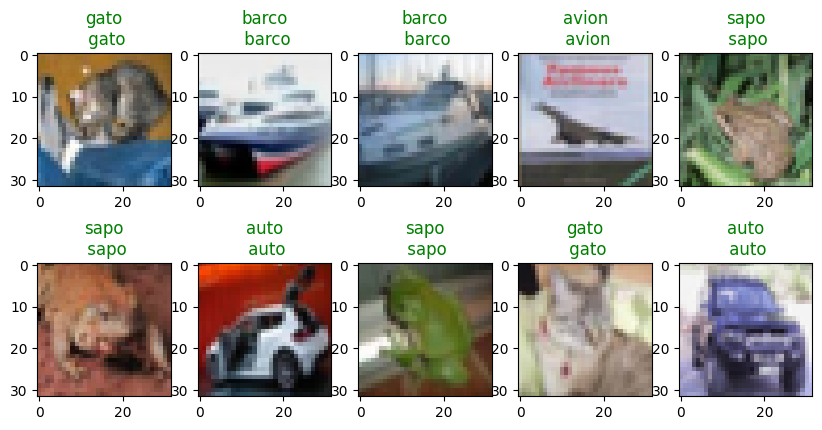

In [38]:
from mlflow.tracking import MlflowClient
import mlflow.pyfunc
mlflow.set_tracking_uri("http://localhost:5000")
run_id = '6fc13426435e4616a6868b9e8f4c2e85'
client = MlflowClient()
train_accuracy_history = client.get_metric_history(run_id,"train_accuracy")
train_loss_history = client.get_metric_history(run_id,"train_loss")
val_accuracy_history = client.get_metric_history(run_id,"val_accuracy")
val_loss_history = client.get_metric_history(run_id,"val_loss")

history = {
    "train_accuracy": [accuracy.value for i,accuracy in enumerate (train_accuracy_history) if i != len(train_accuracy_history)-1],
    "train_loss": [loss.value for i,loss in enumerate(train_loss_history) if i != len(train_loss_history)-1],
    "val_accuracy": [accuracy.value for i,accuracy in enumerate(val_accuracy_history) if i != len(val_accuracy_history)-1],
    "val_loss": [loss.value for i,loss in enumerate(val_loss_history) if i != len(val_loss_history)-1],
}

model = keras.models.load_model("best_model.keras")
y_pred = model.predict(x_test)

predichos = []
reales = []
clase_pred = []
for i in range(0,len(y_pred)):
    clase_pred.append(np.argmax(y_pred[i]))
    if np.argmax(y_pred[i]) == y_test[i]:
        predichos.append(1)
        reales.append(1)
    else:
        predichos.append(1)
        reales.append(0)

    
print("La cantidad de aciertos es:",np.count_nonzero(reales))

#grafica de las clases acertadas
fig, axes = plt.subplots(2,5,figsize=(10,5))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test[i])
    clase_predecida = class_names[clase_pred[i]]
    clase_real = class_names[y_test[i]]
    color = "green" if clase_predecida == clase_real else "red"
    ax.set_title(f"{clase_predecida}\n {clase_real}", color=color)
    
plt.show()

#grafico de la matriz de confusion
# predichos = np.array(predichos).reshape(10000)
# reales = np.array(reales).reshape(10000)
cm = confusion_matrix(predichos,reales)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels = ['Negative', 'Positive'],
            yticklabels = ['Negative', 'Positive'])


plt.xlabel("prediccion")
plt.ylabel('Real')
plt.title("Matriz de confusion")
plt.show()

#graficos para la precision y el error
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(history['train_accuracy'], label='Entrenamiento')
ax1.plot(history['val_accuracy'], label='Validacion')
ax1.set_title('Curva de precision')
ax1.set_xlabel('Epoca')
ax1.set_ylabel('Precision')
ax1.legend()

ax2.plot(history['train_loss'], label='Entrenamiento')
ax2.plot(history['val_loss'], label='Validacion')
ax2.set_title('Curva de perdida')
ax2.set_xlabel('Epoca')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()
